## Importamos as bibliotecas

In [2]:
import numpy as np
import cv2
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Baixamos o dataset

In [3]:

# Configuração para evitar logs desnecessários
tf.get_logger().setLevel('ERROR')

# Defina o caminho da pasta principal onde estão os dados
pasta = "/kaggle/input/the-algae-cell-images/algae_data_11"

# Verificar se a pasta foi extraída corretamente
if not os.path.exists(pasta):
    print("Erro: O dataset não foi extraído corretamente.")
else:
    print("Dataset extraído com sucesso!")

# Inicialize os arrays para armazenar os dados e os rótulos
dataset = []
label = []
SIZE = 224

# Obtenha a lista de categorias (subpastas)
categorias = [d for d in os.listdir(pasta) if os.path.isdir(os.path.join(pasta, d))]

# Iterar sobre cada categoria
for label_idx, categoria in enumerate(categorias):
    subpasta = os.path.join(pasta, categoria)
    imagens = [img for img in os.listdir(subpasta) if img.endswith('.jpg')]

    for image_name in imagens:
        img_path = os.path.join(subpasta, image_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            img = img.resize((SIZE, SIZE))
            dataset.append(np.array(img))
            label.append(label_idx)

print(f"Dataset criado com {len(dataset)} imagens e {len(label)} rótulos.")


Dataset extraído com sucesso!
Dataset criado com 6300 imagens e 6300 rótulos.


## Processamos os dados

In [4]:


# Pré-processamento dos dados
def preprocess_data(X, Y):
    X = X.astype('float32')
    X_p = preprocess_input(X)
    Y_p = to_categorical(Y, len(categorias))
    return X_p, Y_p

# Conversão para numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Divisão dos dados
X_train, X_temp, Y_train, Y_temp = train_test_split(dataset, label, 
                                                    test_size=0.4, 
                                                    random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, 
                                                Y_temp, 
                                                test_size=0.5, 
                                                random_state=42)

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_val_p, Y_val_p = preprocess_data(X_val, Y_val)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


## Definimos o modelo

In [11]:

# Construção do modelo
base_model = VGG16(include_top=False, 
                   weights='imagenet', 
                   pooling='avg', 
                   input_shape=(224, 224, 3))

# Dicionário para armazenar os históricos de treinamento
history_dict = {}

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(len(categorias), activation='softmax')
])

# Callbacks
def decay(epoch):
    """Função para ajustar a taxa de aprendizado."""
    return 0.001 / (1 + 1 * 20)

# Lista de callbacks
callbacks = [
    LearningRateScheduler(decay, verbose=1),
    ModelCheckpoint('phytoplankton.keras', 
                    save_best_only=True, 
                    monitor='val_loss', 
                    mode='min')
]

# Compilação do modelo
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


## Treinamos o modelo

In [16]:

# Treinamento
for batch_size in [8, 16, 32, 64]:
    history = model.fit(X_train_p, 
                        Y_train_p, 
                        batch_size=batch_size, 
                        validation_data=(X_val_p, Y_val_p), 
                        epochs=100, 
                        shuffle=True, 
                        callbacks=callbacks,
                        verbose=1)

# Armazena o histórico de treinamento no dicionário
history_dict[batch_size] = history


Epoch 1: LearningRateScheduler setting learning rate to 4.761904761904762e-05.
Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 106s 189ms/step - accuracy: 0.7468 - loss: 0.9195 - val_accuracy: 0.7651 - val_loss: 0.7540 - learning_rate: 4.7619e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.761904761904762e-05.
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 79s 166ms/step - accuracy: 0.8012 - loss: 0.6301 - val_accuracy: 0.8302 - val_loss: 0.5904 - learning_rate: 4.7619e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.761904761904762e-05.
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 80s 170ms/step - accuracy: 0.8714 - loss: 0.3977 - val_accuracy: 0.8333 - val_loss: 0.5251 - learning_rate: 4.7619e-05

Epoch 4: LearningRateScheduler setting learning rate to 4.761904761904762e-05.
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.8821 - loss: 0.3818 - val_accuracy: 0.9000 - val_loss: 0.3633 - learning_rate: 4.7619e-05

Epoch 5: LearningRateScheduler setting

## Visualizamos o comportamento do modelo

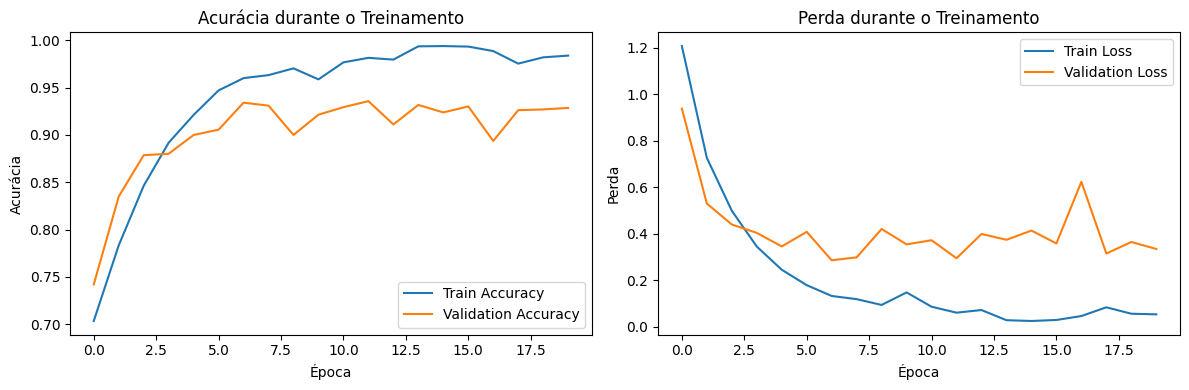

In [7]:
import matplotlib.pyplot as plt

# Função para plotar os gráficos de acurácia e perda
def plot_training_history(history):
    # Gráfico de acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Acurácia durante o Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Perda durante o Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Após o treinamento, chame a função para gerar os gráficos
plot_training_history(history)

## Avaliamos o melhor modelo com os dados de teste

In [ ]:
# Avaliação do modelo
score = model.evaluate(X_test_p, Y_test_p)
print('Test loss:', score[0])
print('Test accuracy:', score[1])